In [17]:
import os
import numpy as np
from scipy.io import wavfile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
# Hàm trích xuất đặc trưng từ file âm thanh
def extract_feature(file_path):
    try:
        rate, data = wavfile.read(file_path)  # Đọc file âm thanh
        # Trích xuất các đặc trưng: giá trị trung bình, độ lệch chuẩn, giá trị lớn nhất, trung vị và giá trị bình phương trung bình
        return np.mean(np.abs(data)), np.std(data), np.max(np.abs(data)), \
               np.median(np.abs(data)), np.mean(np.square(data))
    except Exception as e:
        print(f"Lỗi khi xử lý file {file_path}: {str(e)}")
        return None

In [19]:
# Hàm tải và trích xuất dữ liệu từ thư mục
def load_data(data_path, limit=None):
    features = []
    labels = []
    count = 0
    for subdir, _, files in os.walk(data_path):  # Duyệt qua các thư mục con
        for file in files:
            if file.endswith('.wav'):  # Chỉ xử lý các file âm thanh .wav
                file_path = os.path.join(subdir, file)
                feature = extract_feature(file_path)  # Trích xuất đặc trưng
                if feature is not None:
                    features.append(feature)  # Lưu đặc trưng vào danh sách
                    label = int(file.split('-')[2]) - 1  # Lấy nhãn từ tên file
                    labels.append(label)
                    count += 1
                    if limit and count >= limit:  # Giới hạn số lượng dữ liệu
                        return np.array(features), np.array(labels)
    return np.array(features), np.array(labels)

In [20]:
# Hàm vẽ ma trận nhầm lẫn
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)  # Tạo ma trận nhầm lẫn
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)  # Vẽ heatmap
    plt.title('Ma trận nhầm lẫn')
    plt.ylabel('Thực tế')
    plt.xlabel('Dự đoán')
    plt.show()

In [21]:
# Đường dẫn đến thư mục chứa dữ liệu âm thanh
data_path = '/content/ravdess_data'

# Tải và trích xuất dữ liệu
print("Đang tải và trích xuất đặc trưng từ dữ liệu...")
features, labels = load_data(data_path)

Đang tải và trích xuất đặc trưng từ dữ liệu...


<ipython-input-18-1e5feb5e04b7>:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, data = wavfile.read(file_path)  # Đọc file âm thanh


Đang huấn luyện mô hình...
Đánh giá mô hình:
              precision    recall  f1-score   support

           0       0.39      0.35      0.37        20
           1       0.44      0.62      0.52        40
           2       0.24      0.21      0.22        38
           3       0.28      0.22      0.25        36
           4       0.66      0.52      0.58        44
           5       0.30      0.17      0.22        46
           6       0.30      0.32      0.31        31
           7       0.25      0.42      0.32        33

    accuracy                           0.36       288
   macro avg       0.36      0.36      0.35       288
weighted avg       0.36      0.36      0.35       288



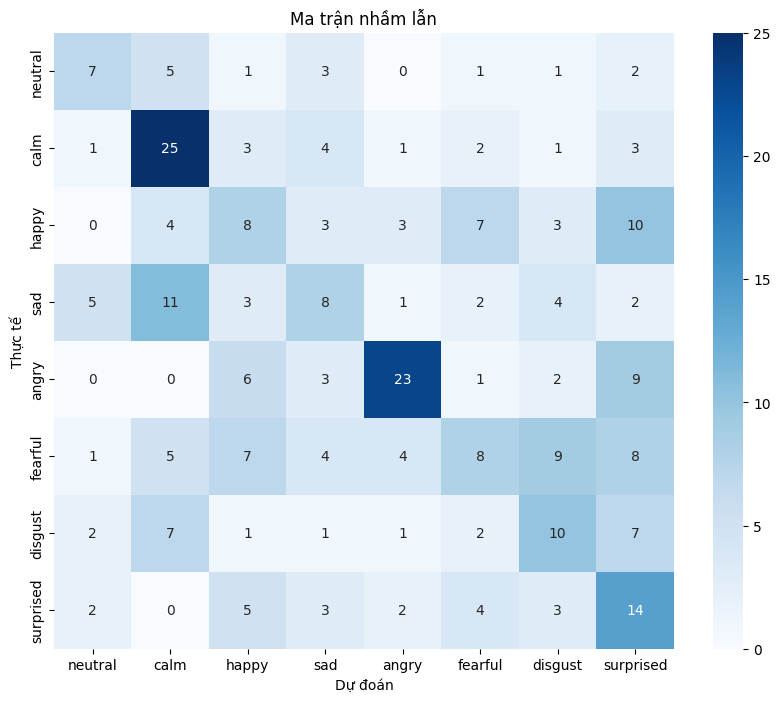

In [22]:
# Kiểm tra xem có dữ liệu hay không
if len(features) == 0:
    print("Không tìm thấy dữ liệu. Vui lòng kiểm tra lại đường dẫn và định dạng file.")
else:
    # Chia dữ liệu thành tập huấn luyện và kiểm tra
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    # Chuẩn hóa dữ liệu (Standardization)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)  # Chuẩn hóa tập huấn luyện
    X_test_scaled = scaler.transform(X_test)  # Chuẩn hóa tập kiểm tra

    # Xây dựng và huấn luyện mô hình Random Forest
    print("Đang huấn luyện mô hình...")
    model = RandomForestClassifier(n_estimators=200, random_state=42)
    model.fit(X_train_scaled, y_train)

    # Đánh giá mô hình với tập kiểm tra
    print("Đánh giá mô hình:")
    y_pred = model.predict(X_test_scaled)
    print(classification_report(y_test, y_pred))  # Báo cáo độ chính xác và các chỉ số khác

    # Vẽ ma trận nhầm lẫn
    emotions = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
    plot_confusion_matrix(y_test, y_pred, emotions)

    # Hàm dự đoán cảm xúc từ file âm thanh
    def predict_emotion(file_path):
        feature = extract_feature(file_path)
        if feature is not None:
            feature_scaled = scaler.transform([feature])  # Chuẩn hóa đặc trưng của file
            prediction = model.predict(feature_scaled)  # Dự đoán nhãn
            return emotions[prediction[0]]  # Trả về nhãn cảm xúc
        else:
            return "Không thể dự đoán"

In [23]:
    # Dự đoán cảm xúc từ file mẫu
    print("\nDự đoán cảm xúc từ file mẫu:")
    sample_file = os.path.join(data_path, 'Actor_01', '03-01-01-01-01-01-01.wav')
    if os.path.exists(sample_file):
        print(f"Cảm xúc dự đoán: {predict_emotion(sample_file)}")
    else:
        print(f"Không tìm thấy file mẫu: {sample_file}")



Dự đoán cảm xúc từ file mẫu:
Cảm xúc dự đoán: neutral


<ipython-input-18-1e5feb5e04b7>:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, data = wavfile.read(file_path)  # Đọc file âm thanh
